In [101]:
import pandas as pd
from pathlib import Path

# >> Kohanda teed vastavalt oma arvutis asuvale failile <<
tarb_path = Path(r"C:\Users\opilane\Documents\andmetarkus\Python\elekter\Tarb_aug24.xlsx")
temp_path = Path(r"C:\Users\opilane\Documents\andmetarkus\Python\elekter\Temp_aug24.xlsx")


In [102]:
def read_any_excel(p: Path) -> pd.DataFrame:
    """Loeb Exceli. Kui laiend oli kogemata .xlsx, proovi .xlsx."""
    try:
        return pd.read_excel(p, engine="openpyxl")
    except Exception:
        if p.suffix.lower() == ".xlsx":
            alt = p.with_suffix(".xlsx")
            return pd.read_excel(alt, engine="openpyxl")
        raise

def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Trimmib veerunimed, asendab tühikud alakriipsuga ja teeb väiketäheks."""
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
        .str.lower()
    )
    return df

def ensure_numeric(series: pd.Series) -> pd.Series:
    """Teisendab veeru kindlalt arvuliseks (eemaldab kõvad tühikud, ruumid; koma->punkt)."""
    if pd.api.types.is_numeric_dtype(series):
        return pd.to_numeric(series, errors="coerce")
    s = (
        series.astype(str)
        .str.replace("\u00A0", "", regex=False)  # kõva tühik
        .str.replace(" ", "", regex=False)
        .str.replace(",", ".", regex=False)      # kui koma on kümnend
    )
    return pd.to_numeric(s, errors="coerce")


In [103]:
tarb = read_any_excel(tarb_path)
temp = read_any_excel(temp_path)

tarb = clean_columns(tarb)   # eeldab: kpv, aeg, tarbimine
temp = clean_columns(temp)   # eeldab: kpv, aeg, temperatuur (mõnikord 'temp')

print("Tarb veerunimed:", tarb.columns.tolist())
print("Temp veerunimed:", temp.columns.tolist())
tarb.head()


Tarb veerunimed: ['kpv', 'aeg', 'tarbimine']
Temp veerunimed: ['kpv', 'aeg', 'temperatuur']


,kpv,aeg,tarbimine
0,2024-09-01,00:00:00,619.5
1,2024-09-01,01:00:00,585.4
2,2024-09-01,02:00:00,563.0
3,2024-09-01,03:00:00,554.0
4,2024-09-01,04:00:00,555.5


In [104]:
if "temp" in temp.columns and "temperatuur" not in temp.columns:
    temp = temp.rename(columns={"temp": "temperatuur"})

# Kiire kontroll, et nõutud veerud on olemas
required_tarb = {"kpv", "aeg", "tarbimine"}
required_temp = {"kpv", "aeg", "temperatuur"}

missing_tarb = required_tarb - set(tarb.columns)
missing_temp = required_temp - set(temp.columns)

print("Puuduvad Tarb veerud:", missing_tarb)
print("Puuduvad Temp veerud:", missing_temp)

if missing_tarb or missing_temp:
    raise ValueError("Kontrolli failide veerunimesid. Vaata eelmise raku printi ja kohanda.")


Puuduvad Tarb veerud: set()
Puuduvad Temp veerud: set()


In [105]:
tarb["datetime"] = pd.to_datetime(tarb["kpv"].astype(str) + " " + tarb["aeg"].astype(str),
                                  dayfirst=True, errors="coerce")
temp["datetime"] = pd.to_datetime(temp["kpv"].astype(str) + " " + temp["aeg"].astype(str),
                                  dayfirst=True, errors="coerce")

# Eemalda vigaste ajatemplitega read
tarb = tarb.dropna(subset=["datetime"]).copy()
temp = temp.dropna(subset=["datetime"]).copy()

tarb[["kpv","aeg","datetime"]].head()


,kpv,aeg,datetime
0,2024-09-01,00:00:00,2024-01-09 00:00:00
1,2024-09-01,01:00:00,2024-01-09 01:00:00
2,2024-09-01,02:00:00,2024-01-09 02:00:00
3,2024-09-01,03:00:00,2024-01-09 03:00:00
4,2024-09-01,04:00:00,2024-01-09 04:00:00


In [106]:
tarb["tarbimine"]   = ensure_numeric(tarb["tarbimine"])
temp["temperatuur"] = ensure_numeric(temp["temperatuur"])

# Soovi korral eemalda read, kus väärtused puuduvad
tarb = tarb.dropna(subset=["tarbimine"]).copy()
temp = temp.dropna(subset=["temperatuur"]).copy()

tarb[["tarbimine"]].describe(), temp[["temperatuur"]].describe()


(         tarbimine
 count  3454.000000
 mean    902.288940
 std     182.751507
 min     482.300000
 25%     763.100000
 50%     887.150000
 75%    1032.800000
 max    1400.200000,
        temperatuur
 count  3397.000000
 mean      7.037119
 std       8.359632
 min     -10.364006
 25%       0.230743
 50%       5.959967
 75%      14.194691
 max      29.686325)

In [107]:
df = pd.merge(
    tarb[["datetime", "tarbimine"]],
    temp[["datetime", "temperatuur"]],
    on="datetime",
    how="inner"
).sort_values("datetime")

print("Ridu pärast merge'i:", len(df))
df.head()


Ridu pärast merge'i: 3395


,datetime,tarbimine,temperatuur
0,2024-01-09 01:00:00,585.4,12.346786
1,2024-01-09 02:00:00,563.0,12.546382
2,2024-01-09 03:00:00,554.0,12.196983
3,2024-01-09 04:00:00,555.5,11.887848
4,2024-01-09 05:00:00,566.5,11.732937


In [88]:
pearson  = df["tarbimine"].corr(df["temperatuur"], method="pearson")
spearman = df["tarbimine"].corr(df["temperatuur"], method="spearman")

print(f"Pearsoni korrelatsioon (lineaarne seos): {pearson:.3f}")
print(f"Spearmani korrelatsioon (monotoonne seos): {spearman:.3f}")

df[["tarbimine","temperatuur"]].corr(method="pearson")


Pearsoni korrelatsioon (lineaarne seos): -0.567
Spearmani korrelatsioon (monotoonne seos): -0.577


,tarbimine,temperatuur
tarbimine,1.000000,-0.566664
temperatuur,-0.566664,1.000000


In [89]:
# Kasuta resample'i, kui üks on nt 10-minutiline ja teine tunnine
tarb_h = (tarb.set_index("datetime").resample("H").mean(numeric_only=True).dropna().reset_index())
temp_h = (temp.set_index("datetime").resample("H").mean(numeric_only=True).dropna().reset_index())

df_h = pd.merge(
    tarb_h[["datetime", "tarbimine"]],
    temp_h[["datetime", "temperatuur"]],
    on="datetime",
    how="inner"
).sort_values("datetime")

print("Ridu pärast tunnipõhist resample'it ja merge'i:", len(df_h))

pearson_h  = df_h["tarbimine"].corr(df_h["temperatuur"], method="pearson")
spearman_h = df_h["tarbimine"].corr(df_h["temperatuur"], method="spearman")

print(f"[H-tase] Pearson:  {pearson_h:.3f}")
print(f"[H-tase] Spearman: {spearman_h:.3f}")


Ridu pärast tunnipõhist resample'it ja merge'i: 3395
[H-tase] Pearson:  -0.567
[H-tase] Spearman: -0.577


C:\Users\opilane\AppData\Local\Temp\ipykernel_11768\2112666260.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tarb_h = (tarb.set_index("datetime").resample("H").mean(numeric_only=True).dropna().reset_index())
C:\Users\opilane\AppData\Local\Temp\ipykernel_11768\2112666260.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp_h = (temp.set_index("datetime").resample("H").mean(numeric_only=True).dropna().reset_index())


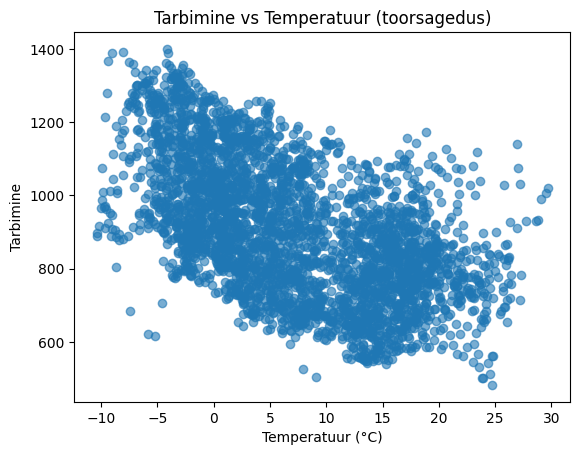

In [90]:
import matplotlib.pyplot as plt

plt.scatter(df["temperatuur"], df["tarbimine"], alpha=0.6)
plt.xlabel("Temperatuur (°C)")
plt.ylabel("Tarbimine")
plt.title("Tarbimine vs Temperatuur (toorsagedus)")
plt.show()


In [91]:
out_path = Path(r"C:\Users\opilane\Documents\andmetarkus\Python\elekter\Tarb_Temp_merged.csv")
df.to_csv(out_path, index=False)
out_path


WindowsPath('C:/Users/opilane/Documents/andmetarkus/Python/elekter/Tarb_Temp_merged.csv')

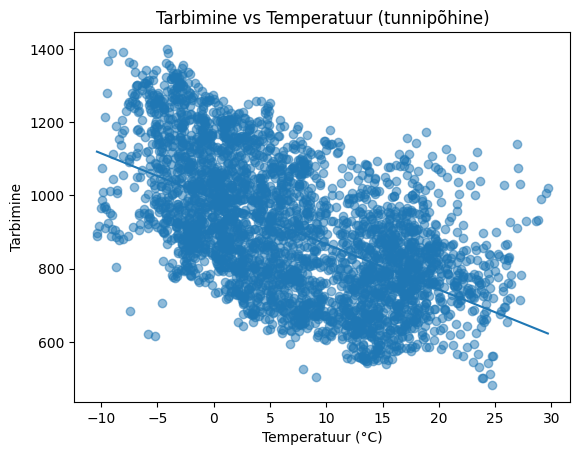

Lihtne regressioon: tarbimine ≈ 991.04 + -12.41 * temperatuur


In [92]:
import numpy as np
import matplotlib.pyplot as plt

x = df_h["temperatuur"].to_numpy()
y = df_h["tarbimine"].to_numpy()

# lihtne OLS sirge parameetrid
b1, b0 = np.polyfit(x, y, 1)  # y ≈ b0 + b1*x

plt.scatter(x, y, alpha=0.5)
xx = np.linspace(x.min(), x.max(), 100)
plt.plot(xx, b0 + b1*xx)  # regressioonijoon
plt.title("Tarbimine vs Temperatuur (tunnipõhine)")
plt.xlabel("Temperatuur (°C)")
plt.ylabel("Tarbimine")
plt.show()

print(f"Lihtne regressioon: tarbimine ≈ {b0:.2f} + {b1:.2f} * temperatuur")


In [93]:
df_d = df_h.copy()
df_d["hour"] = df_d["datetime"].dt.hour

df_d["tarb_detr"]  = df_d["tarbimine"]   - df_d.groupby("hour")["tarbimine"].transform("mean")
df_d["temp_detr"]  = df_d["temperatuur"] - df_d.groupby("hour")["temperatuur"].transform("mean")

print("Korrelatsioon pärast tunnimustri eemaldamist:",
      df_d["tarb_detr"].corr(df_d["temp_detr"]))


Korrelatsioon pärast tunnimustri eemaldamist: -0.7451575974974393


In [94]:
def lagcorr(y, x, lags=range(-12, 13)):  # ±12 tundi
    out = []
    for k in lags:
        out.append((k, y.corr(x.shift(k))))
    return pd.DataFrame(out, columns=["lag", "corr"]).sort_values("lag")

res = lagcorr(df_h["tarbimine"], df_h["temperatuur"], lags=range(-24, 25))
display(res)
best = res.iloc[res["corr"].abs().argmax()]
print(f"Parim lag: {best['lag']} tundi, korrelatsioon: {best['corr']:.3f}")


,lag,corr
0,-24,-0.110199
1,-23,-0.133269
2,-22,-0.159217
3,-21,-0.188315
4,-20,-0.220367
5,-19,-0.254866
6,-18,-0.291145
7,-17,-0.328244
8,-16,-0.363610
9,-15,-0.395491


Parim lag: 0.0 tundi, korrelatsioon: -0.567


In [95]:
# vajadusel: pip install statsmodels
import statsmodels.formula.api as smf

df_m = df_h.copy()
df_m["hour"] = df_m["datetime"].dt.hour
df_m["dow"]  = df_m["datetime"].dt.dayofweek  # 0=Mon ... 6=Sun

model = smf.ols("tarbimine ~ temperatuur + C(hour) + C(dow)", data=df_m).fit()
print(model.summary())

coef = model.params["temperatuur"]
print(f"Temperatuuri mõju (kontrollides hour & dow): {coef:.3f} ühikut / 1°C")


                            OLS Regression Results                            
Dep. Variable:              tarbimine   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     242.1
Date:                Wed, 10 Sep 2025   Prob (F-statistic):               0.00
Time:                        14:17:09   Log-Likelihood:                -20550.
No. Observations:                3395   AIC:                         4.116e+04
Df Residuals:                    3364   BIC:                         4.135e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       879.2342      9.792     89.795